## Coding Discussion 06 - Week 12
### 15 November 2020
#### Kryslette Bunyi

# Instructions

Building off what we did in lecture this week, please build a model that predicts the _log_ selling price of a house in DC (`PRICE`). Please use what you've learned of the `sklearn` library to accomplish this task.  

I've split this dataset into a training and test dataset (so you don't need to split it on your own). Using the training data, build a model that predicts the price of a residential unit in District of Columbia.

You may use any feature in the dataset to generate a model. Some things to keep in mind:

- Be sure to predict the log Price, not the raw Price
- Be sure to pre-process your data. 
- Be careful of missing data values. You can do whatever you like with them. 
- Try different models, some algorithms perform better on a specific data outcome than others. 
- Be sure to tune your model (if it has relevant tuning parameters).

Once you've come up with a model that you think performs well, please test your model on the provided test data and report the mean squared error. 

# Data 

The provided data comes from the D.C. Residential Properties dataset downloaded from Kaggle and available via Open Data DC. The following provides a description of the data as provided at this [link](https://dcdatahub.maps.arcgis.com/sharing/rest/content/items/c5fb3fbe4c694a59a6eef7bf5f8bc49a/info/metadata/metadata.xml?format=default&output=html):

> Computer Assisted Mass Appraisal (CAMA) database. The dataset contains attribution on housing characteristics for residential properties, and was created as part of the DC Geographic Information System (DC GIS) for the DC Office of the Chief Technology Officer (OCTO) and participating D.C. government agencies. This data is used for the planning and management of Washington, D.C. by local government agencies.

Again, the data has been pre-split into a training and test dataset.

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [2]:
# Read in data
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

# Check sizes of datasets
print("train:",train.shape)
print("test:",test.shape)

train: (43590, 39)
test: (14531, 39)


In [3]:
# Available features
list(train)

['OBJECTID',
 'SSL',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'HEAT_D',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STYLE_D',
 'STRUCT',
 'STRUCT_D',
 'GRADE',
 'GRADE_D',
 'CNDTN',
 'CNDTN_D',
 'EXTWALL',
 'EXTWALL_D',
 'ROOF',
 'ROOF_D',
 'INTWALL',
 'INTWALL_D',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'LN_PRICE']

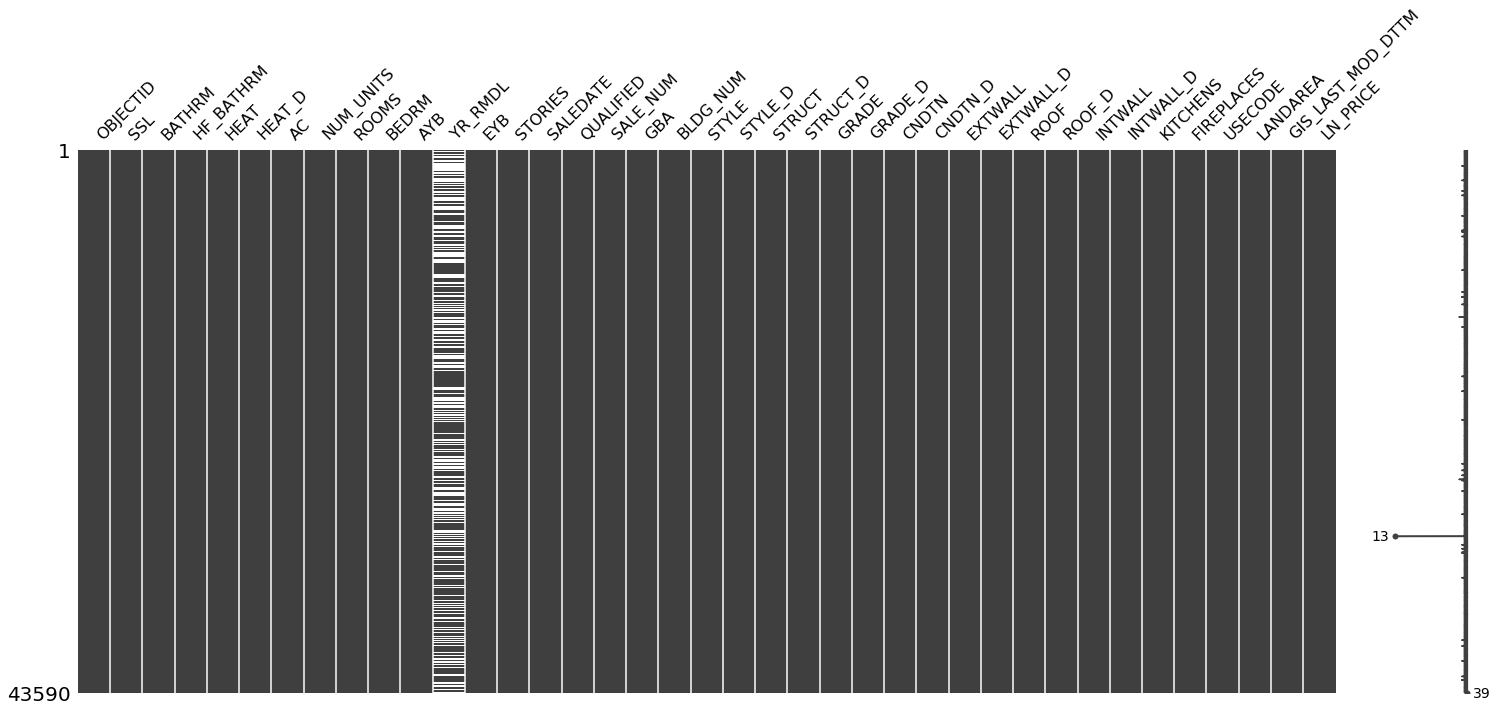

In [4]:
# Assess missingness
miss.matrix(train)

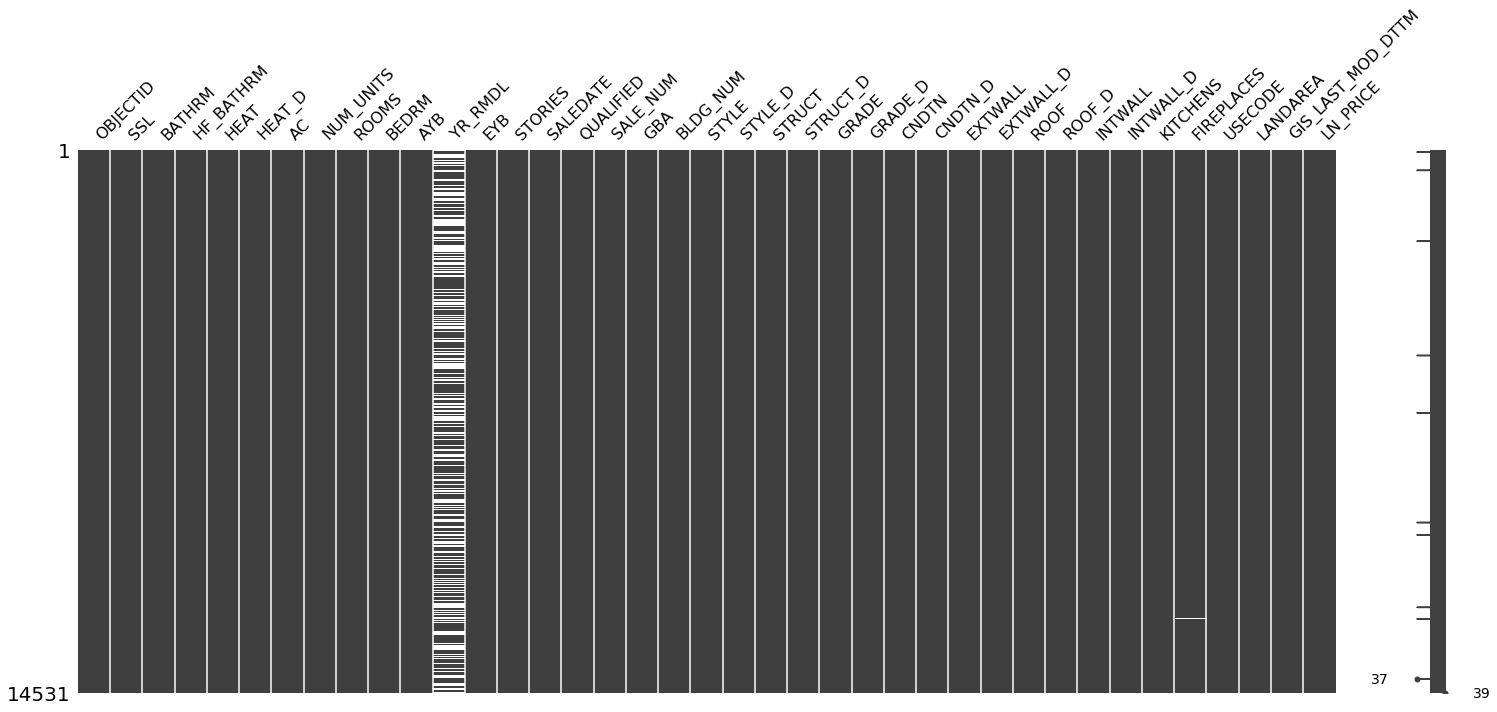

In [5]:
# Assess missingness
miss.matrix(test)

In [6]:
# Narrow to numerical predictors (i.e., drop categorical variables)
train = train[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'EYB', 'STORIES', 'GBA', 'GRADE', 'CNDTN', 'KITCHENS', 'FIREPLACES', 'LANDAREA','LN_PRICE']]
test = test[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'EYB', 'STORIES', 'GBA', 'GRADE', 'CNDTN', 'KITCHENS', 'FIREPLACES', 'LANDAREA','LN_PRICE']]

In [7]:
# Check missing data
train.isna().sum()

BATHRM         1
HF_BATHRM      2
NUM_UNITS      1
ROOMS         11
BEDRM          4
AYB            4
EYB            0
STORIES       29
GBA            0
GRADE          1
CNDTN          1
KITCHENS       2
FIREPLACES     1
LANDAREA       0
LN_PRICE       0
dtype: int64

In [8]:
# Check missing data
test.isna().sum()

BATHRM        0
HF_BATHRM     0
NUM_UNITS     0
ROOMS         2
BEDRM         0
AYB           1
EYB           0
STORIES       7
GBA           0
GRADE         0
CNDTN         0
KITCHENS      0
FIREPLACES    1
LANDAREA      0
LN_PRICE      0
dtype: int64

Compared to the size of our datasets, observations with missing data appear to be negligible. We can then drop them for simplicity.

In [9]:
train_nonull = train.dropna()
train_nonull

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,STORIES,GBA,GRADE,CNDTN,KITCHENS,FIREPLACES,LANDAREA,LN_PRICE
0,3.0,1.0,1.0,9.0,4.0,1939.0,1969,2.0,1260,5.0,5.0,1.0,0.0,2234,13.591116
1,2.0,1.0,1.0,7.0,3.0,1938.0,1972,2.0,1426,6.0,5.0,1.0,1.0,3850,12.730801
2,2.0,2.0,1.0,9.0,4.0,1940.0,1980,2.5,2270,6.0,3.0,1.0,1.0,7866,13.651814
3,1.0,1.0,1.0,6.0,3.0,1952.0,1952,2.0,1278,3.0,3.0,1.0,0.0,2739,12.860999
4,2.0,0.0,1.0,11.0,4.0,1885.0,1950,2.0,2936,5.0,3.0,1.0,0.0,2097,14.100690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43585,1.0,0.0,1.0,5.0,2.0,1911.0,1957,2.0,974,4.0,3.0,1.0,1.0,560,12.994530
43586,2.0,1.0,1.0,7.0,3.0,1916.0,1969,2.0,1603,5.0,4.0,1.0,1.0,1483,13.748302
43587,2.0,0.0,1.0,9.0,4.0,1908.0,1957,3.0,2418,4.0,4.0,1.0,2.0,1393,13.353475
43588,3.0,1.0,1.0,6.0,3.0,1911.0,1984,2.0,1442,4.0,4.0,2.0,1.0,878,13.304518


In [10]:
# Verify that there are no more null values
train_nonull.isna().sum()

BATHRM        0
HF_BATHRM     0
NUM_UNITS     0
ROOMS         0
BEDRM         0
AYB           0
EYB           0
STORIES       0
GBA           0
GRADE         0
CNDTN         0
KITCHENS      0
FIREPLACES    0
LANDAREA      0
LN_PRICE      0
dtype: int64

In [11]:
test_nonull = test.dropna()
test_nonull

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,STORIES,GBA,GRADE,CNDTN,KITCHENS,FIREPLACES,LANDAREA,LN_PRICE
0,2.0,1.0,1.0,6.0,3.0,2011.0,2013,3.00,1683,4.0,5.0,1.0,0.0,688,12.409013
1,3.0,0.0,2.0,9.0,4.0,1933.0,1969,2.00,1548,5.0,3.0,2.0,1.0,2064,13.513053
2,4.0,1.0,1.0,10.0,5.0,1967.0,1987,3.00,3840,6.0,4.0,1.0,2.0,4583,14.417091
3,3.0,1.0,1.0,10.0,4.0,1905.0,1969,2.00,1776,5.0,4.0,1.0,2.0,2147,13.547631
4,2.0,0.0,1.0,6.0,3.0,1935.0,1954,2.25,1180,3.0,4.0,1.0,0.0,1576,13.023647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14526,4.0,1.0,1.0,13.0,6.0,1937.0,1969,2.50,2600,5.0,4.0,1.0,2.0,5007,13.976779
14527,1.0,0.0,1.0,7.0,4.0,1910.0,1947,2.00,1800,4.0,3.0,1.0,0.0,2500,11.676744
14528,1.0,1.0,1.0,7.0,3.0,1934.0,1950,2.00,1080,3.0,3.0,1.0,0.0,2826,12.377923
14529,2.0,0.0,1.0,6.0,3.0,1890.0,1957,2.00,1732,4.0,3.0,1.0,1.0,1650,12.886641


In [12]:
# Verify that there are no more null values
test_nonull.isna().sum()

BATHRM        0
HF_BATHRM     0
NUM_UNITS     0
ROOMS         0
BEDRM         0
AYB           0
EYB           0
STORIES       0
GBA           0
GRADE         0
CNDTN         0
KITCHENS      0
FIREPLACES    0
LANDAREA      0
LN_PRICE      0
dtype: int64

In [13]:
# Check for possible data errors
train_nonull[train_nonull.LN_PRICE == 0]

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,STORIES,GBA,GRADE,CNDTN,KITCHENS,FIREPLACES,LANDAREA,LN_PRICE
1212,1.0,1.0,1.0,7.0,3.0,1929.0,1947,2.0,1420,4.0,3.0,1.0,1.0,4400,0.0
42776,3.0,0.0,3.0,14.0,6.0,1953.0,1971,3.0,2150,3.0,3.0,3.0,0.0,7811,0.0


In [14]:
test_nonull[test_nonull.LN_PRICE == 0]

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,STORIES,GBA,GRADE,CNDTN,KITCHENS,FIREPLACES,LANDAREA,LN_PRICE


In [15]:
# Drop all observations where the log prices have zero values as these likely represent missing data (even if e^0 = 1)
# It is safe to drop these as we will drop only 2 data points
train_nonull = train_nonull[train_nonull.LN_PRICE > 0]
test_nonull = test_nonull[test_nonull.LN_PRICE > 0]

In [16]:
# Display minimum and maximum value of each feature to check for data errors
for col in train_nonull.columns:
    print(col, "| MIN:", train_nonull[col].min(), "| MAX:", train_nonull[col].max())

BATHRM | MIN: 0.0 | MAX: 24.0
HF_BATHRM | MIN: 0.0 | MAX: 11.0
NUM_UNITS | MIN: 0.0 | MAX: 6.0
ROOMS | MIN: 0.0 | MAX: 36.0
BEDRM | MIN: 0.0 | MAX: 54.0
AYB | MIN: 0.0 | MAX: 2018.0
EYB | MIN: 1900 | MAX: 2018
STORIES | MIN: 0.0 | MAX: 826.0
GBA | MIN: 0 | MAX: 15902
GRADE | MIN: 0.0 | MAX: 12.0
CNDTN | MIN: 0.0 | MAX: 6.0
KITCHENS | MIN: 0.0 | MAX: 44.0
FIREPLACES | MIN: 0.0 | MAX: 13.0
LANDAREA | MIN: 0 | MAX: 187301
LN_PRICE | MIN: 2.302585092994046 | MAX: 17.038378404102012


In [17]:
# Display minimum and maximum value of each feature to check for data errors
for col in test_nonull.columns:
    print(col, "| MIN:", test_nonull[col].min(), "| MAX:", test_nonull[col].max())

BATHRM | MIN: 0.0 | MAX: 10.0
HF_BATHRM | MIN: 0.0 | MAX: 5.0
NUM_UNITS | MIN: 0.0 | MAX: 5.0
ROOMS | MIN: 0.0 | MAX: 101.0
BEDRM | MIN: 0.0 | MAX: 53.0
AYB | MIN: 0.0 | MAX: 2018.0
EYB | MIN: 1915 | MAX: 2018
STORIES | MIN: 0.0 | MAX: 275.0
GBA | MIN: 252 | MAX: 15673
GRADE | MIN: 2.0 | MAX: 12.0
CNDTN | MIN: 1.0 | MAX: 6.0
KITCHENS | MIN: 0.0 | MAX: 6.0
FIREPLACES | MIN: 0.0 | MAX: 13.0
LANDAREA | MIN: 0 | MAX: 102340
LN_PRICE | MIN: 2.302585092994046 | MAX: 16.991908309436948


There does not seem to be a plausible explanation for AYB, GBA, and LANDAREA to take on zero values, so we assume these are data errors/missing observations. Likewise, based on the description, GRADE = 0 signifies that there is no data. The same goes for CNDTN.

In [18]:
# Remove all identified possible data errors
train_nonull = train_nonull[train_nonull.AYB > 0]
train_nonull = train_nonull[train_nonull.GBA > 0]
train_nonull = train_nonull[train_nonull.LANDAREA > 0]
train_nonull = train_nonull[train_nonull.GRADE > 0]
train_nonull = train_nonull[train_nonull.CNDTN > 0]

In [19]:
# Remove all identified possible data errors
test_nonull = test_nonull[test_nonull.AYB > 0]
test_nonull = test_nonull[test_nonull.GBA > 0]
test_nonull = test_nonull[test_nonull.LANDAREA > 0]
test_nonull = test_nonull[test_nonull.GRADE > 0]
test_nonull = test_nonull[test_nonull.CNDTN > 0]

In [20]:
# Log land area
train_nonull['LANDAREA'] = np.log(train_nonull['LANDAREA'])
test_nonull['LANDAREA'] = np.log(test_nonull['LANDAREA'])

Modeling Pipeline

In [21]:
# (0) Split the data 
train_x = train_nonull[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'EYB', 'STORIES', 'GBA', 'GRADE', 'CNDTN', 'KITCHENS', 'FIREPLACES', 'LANDAREA']]
train_y = train_nonull[['LN_PRICE']]
test_x = test_nonull[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'EYB', 'STORIES', 'GBA', 'GRADE', 'CNDTN', 'KITCHENS', 'FIREPLACES', 'LANDAREA']]
test_y = test_nonull[['LN_PRICE']]

In [29]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=123)

In [30]:
# (2) Pre-Process the Data

preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'STORIES', 'GBA', 'KITCHENS', 'FIREPLACES', 'LANDAREA'])])

In [31]:
# Create model pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [33]:
# Specify the models and test various tuning parameters
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,20,30,50,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

In [34]:
# Put together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

In [35]:
# Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         ['BATHRM',
                     

In [36]:
# Extract best fit score
search.best_score_ 

-0.42901793880444555

In [37]:
# Extract parameters of best model
search.best_params_

{'model': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform'),
 'model__n_neighbors': 50}

Our best model is a KNN algorithm using the nearest 50 neighbors.

In [72]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)

In [73]:
m.r2_score(test_y,pred_y)

0.42097069306279655

In [117]:
print("The mean squared error of our KNN algorithm using the nearest 50 neighbors is:",m.mean_squared_error(test_y,pred_y))

The mean squared error of our KNN algorithm using the nearest 50 neighbors is: 0.4261427508555638


In [118]:
pred_y_2 = pred_y.transpose()
pred_vs_act = pd.DataFrame({'Prediction': pred_y_2[0]})

In [119]:
pred_vs_act["Actual"] = test_y

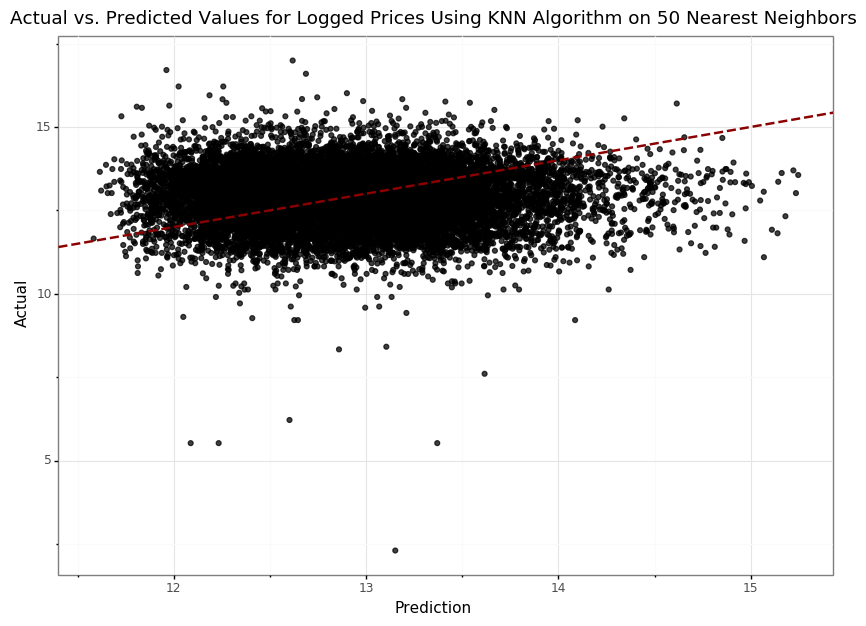

<ggplot: (-9223371908972994656)>

In [125]:
(
    ggplot(pred_vs_act,
          aes(x='Prediction',y="Actual")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    ggtitle("Actual vs. Predicted Values for Logged Prices Using KNN Algorithm on 50 Nearest Neighbors") +
    theme(figure_size=(10,7))
)